In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import numpy as np

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
  root='./dataset/', train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
  root="./dataset/", train=False, transform=transform, download=True
)

train_loader = DataLoader(
  train_dataset, batch_size=128, shuffle=True, num_workers=4
)

test_loader = DataLoader(
  test_dataset, batch_size=32, shuffle=False, num_workers=4
)

In [26]:
class Encoder(nn.Module):
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()
    
    self.encoder_cnn = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
      nn.ReLU(inplace=True),
      
      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(inplace=True),
      
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
      nn.ReLU(inplace=True)
    )
    
    self.flatten = nn.Flatten(start_dim=1)
    
    self.encoder_lin = nn.Sequential(
      nn.Linear(in_features=3 * 3 * 32, out_features=128),
      nn.ReLU(True),
      nn.Linear(in_features=128, out_features=encoded_space_dim)
    )
  
  def forward(self, x):
    x = self.encoder_cnn(x)
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [27]:
class Decoder(nn.Module):
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__()
    self.decoder_lin = nn.Sequential(
      nn.Linear(in_features=encoded_space_dim, out_features=128),
      nn.ReLU(True),
      nn.Linear(in_features=128, out_features=3*3*32),
      nn.ReLU(True)
    )
    
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
    
    self.decoder_conv = nn.Sequential(
      nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3,
                         stride=2, output_padding=0),
      nn.BatchNorm2d(16),
      nn.ReLU(True),
      
      nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3,
                         stride=2, padding=1, output_padding=1),
      nn.BatchNorm2d(8),
      nn.ReLU(True),
      nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3,
                         stride=2, padding=1, output_padding=1)
    )
    
  def forward(self, x):
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x)
    return x

In [28]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)
encoder = nn.DataParallel(encoder)
decoder = nn.DataParallel(decoder)

In [29]:
params_to_optimize = [
  {'params': encoder.parameters()},
  {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [30]:
def add_noise(inputs, noise_factor=0.3):
  noisy = inputs + torch.rand_like(inputs) * noise_factor
  noisy = torch.clip(noisy, 0., 1.)
  return noisy

In [31]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
  encoder.train()
  decoder.train()
  train_loss = []
  for image_batch, _ in dataloader:
    
    image_noisy = add_noise(image_batch, noise_factor)
    image_noisy = image_noisy.to(device)
    
    encoded_data = encoder(image_noisy)
    decoded_data = decoder(encoded_data)
    
    loss = loss_fn(decoded_data, image_noisy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)

In [32]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
  encoder.eval()
  decoder.eval()
  
  with torch.no_grad():
    conc_out = [] # list for each batch's output
    conc_label = []
    for image_batch, _ in dataloader:
      image_batch = image_batch.to(device)
      encoded_data = encoder(image_batch)
      decoded_data = decoder(encoded_data)
      conc_out.append(decoded_data.cpu())
      conc_label.append(image_batch.cpu())
    conc_out = torch.cat(conc_out) # list 형식으로 저장된 모든 값을 하나의 tensor로 생성
    conc_label = torch.cat(conc_label)
    val_loss = loss_fn(conc_out, conc_label)
  return val_loss.data 

In [41]:
# 이미지 시각화 함수
def plot_ae_outpus(encoder, decoder, n=5, noise_factor=0.3):
  plt.figure(figsize=(10, 4.5))
  for i in range(n):
    ax = plt.subplot(3, n, i+1)
    img = test_dataset[i][0].unsqueeze(0)
    image_noisy = add_noise(img, noise_factor)
    
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
      rec_img = decoder(encoder(image_noisy))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('original image')
        
      ax = plt.subplot(3, n , i+1+n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('noised image')
        
      ax = plt.subplot(3, n, i+1+n+n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('reconstructed image')
      
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
  plt.show()
      

Epoch 1/30

 EPOCH 1/30 	 train loss 0.029 	 val loss 0.047


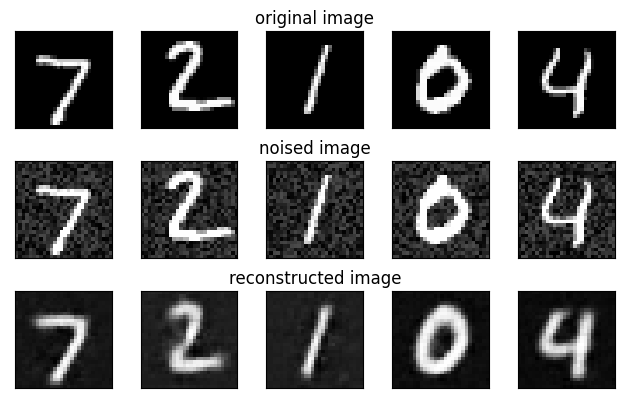

Epoch 2/30

 EPOCH 2/30 	 train loss 0.029 	 val loss 0.046


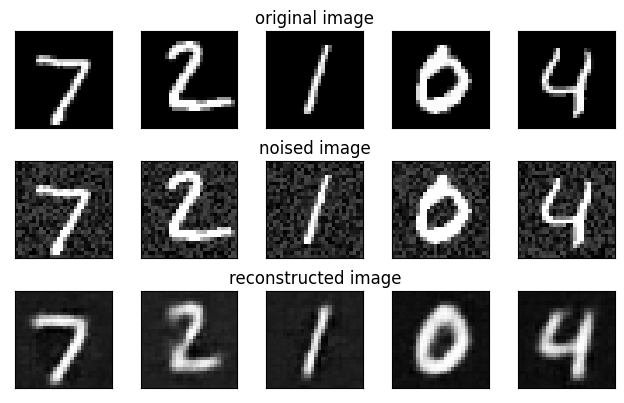

Epoch 3/30

 EPOCH 3/30 	 train loss 0.029 	 val loss 0.046


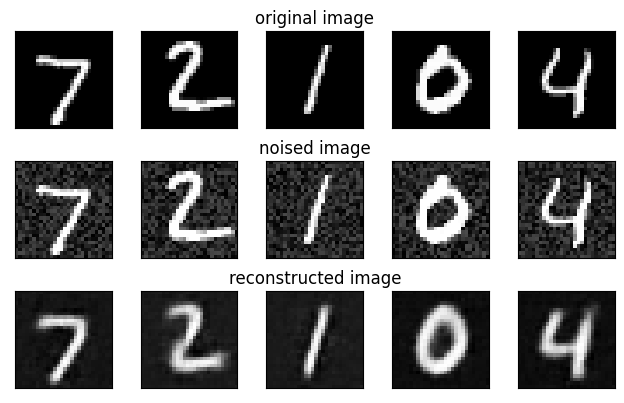

Epoch 4/30

 EPOCH 4/30 	 train loss 0.028 	 val loss 0.046


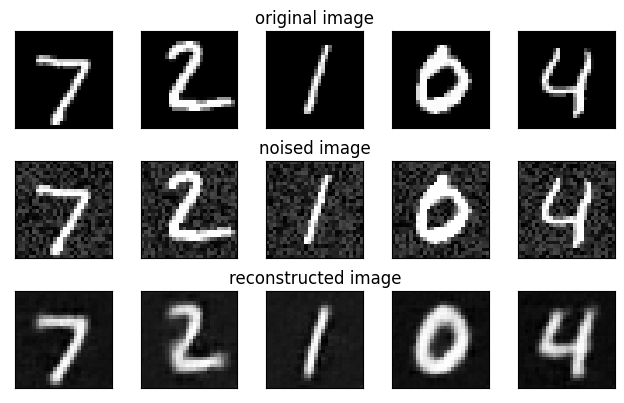

Epoch 5/30

 EPOCH 5/30 	 train loss 0.028 	 val loss 0.047


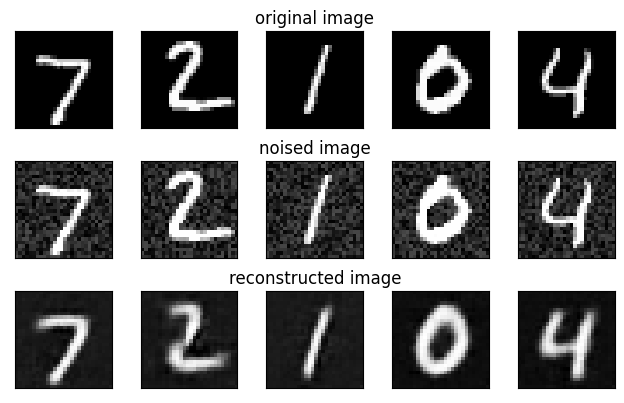

Epoch 6/30

 EPOCH 6/30 	 train loss 0.028 	 val loss 0.046


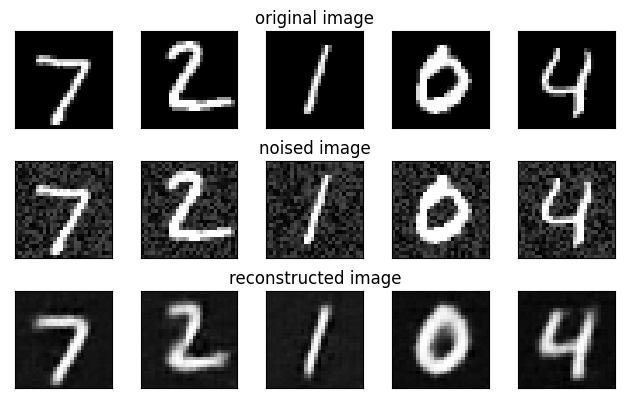

Epoch 7/30

 EPOCH 7/30 	 train loss 0.028 	 val loss 0.046


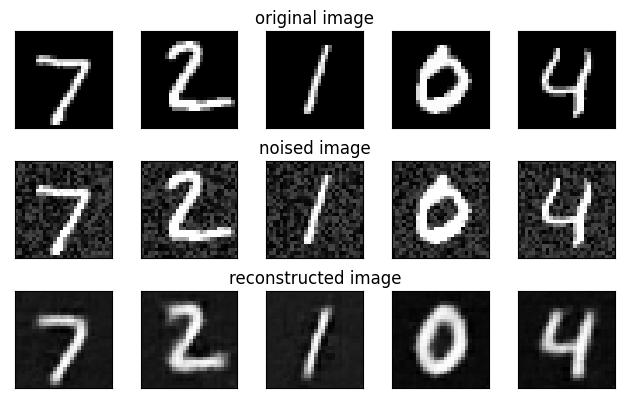

Epoch 8/30

 EPOCH 8/30 	 train loss 0.028 	 val loss 0.046


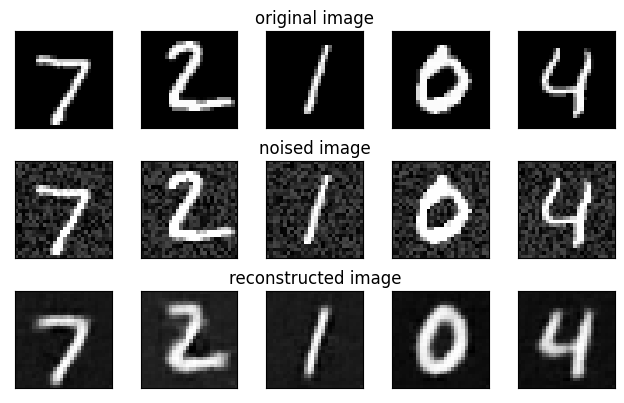

Epoch 9/30

 EPOCH 9/30 	 train loss 0.028 	 val loss 0.046


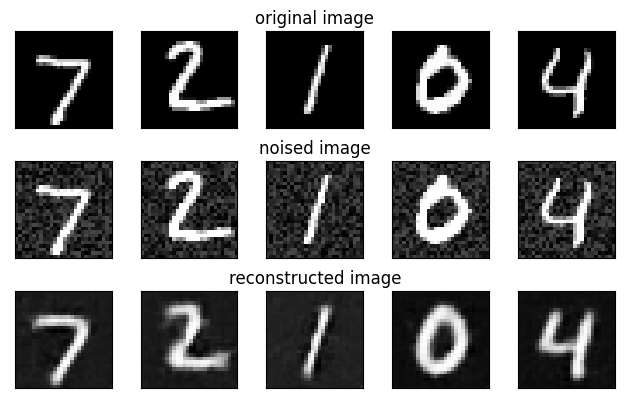

Epoch 10/30

 EPOCH 10/30 	 train loss 0.028 	 val loss 0.045


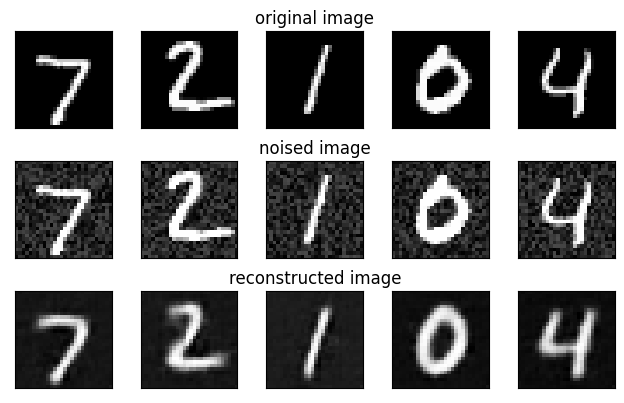

Epoch 11/30

 EPOCH 11/30 	 train loss 0.027 	 val loss 0.045


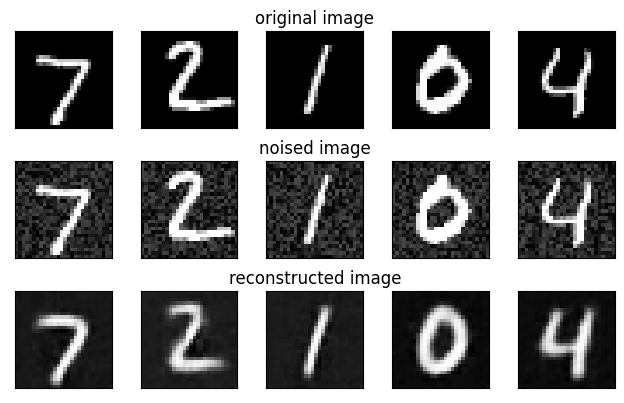

Epoch 12/30

 EPOCH 12/30 	 train loss 0.027 	 val loss 0.045


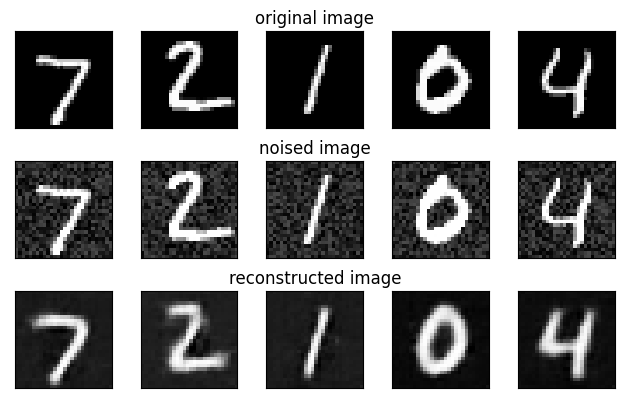

Epoch 13/30

 EPOCH 13/30 	 train loss 0.027 	 val loss 0.045


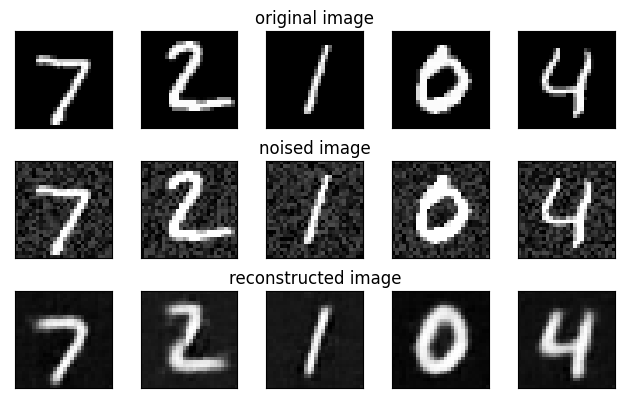

Epoch 14/30

 EPOCH 14/30 	 train loss 0.027 	 val loss 0.045


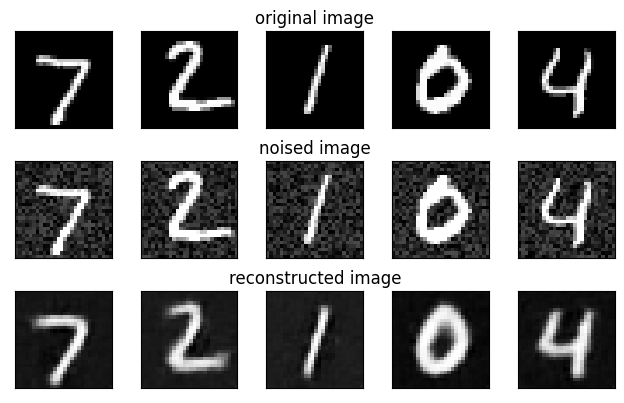

Epoch 15/30

 EPOCH 15/30 	 train loss 0.027 	 val loss 0.046


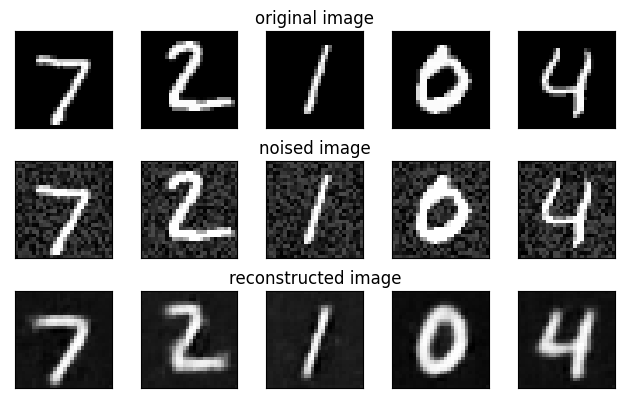

Epoch 16/30

 EPOCH 16/30 	 train loss 0.027 	 val loss 0.045


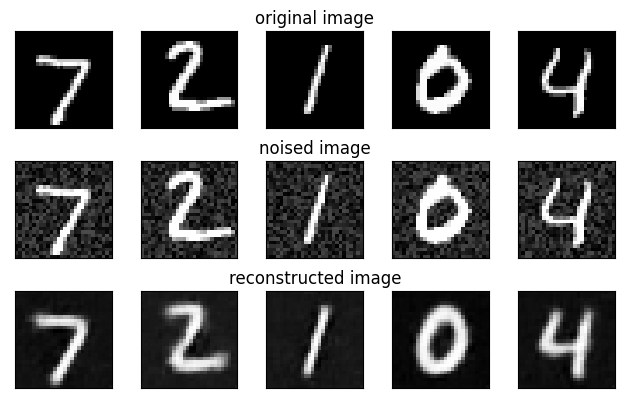

Epoch 17/30

 EPOCH 17/30 	 train loss 0.027 	 val loss 0.045


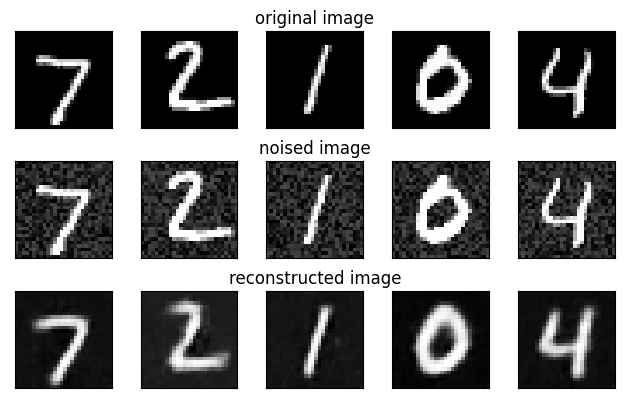

Epoch 18/30

 EPOCH 18/30 	 train loss 0.027 	 val loss 0.045


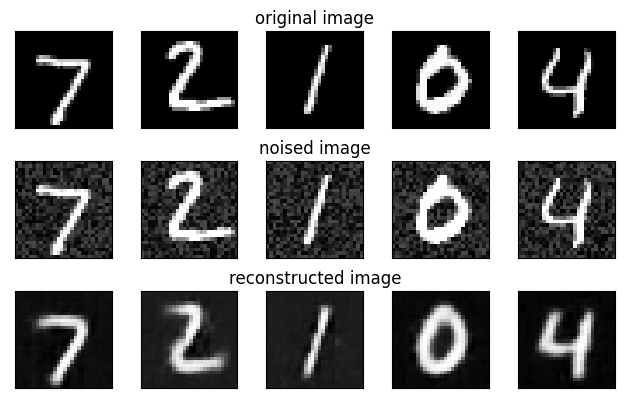

Epoch 19/30

 EPOCH 19/30 	 train loss 0.027 	 val loss 0.044


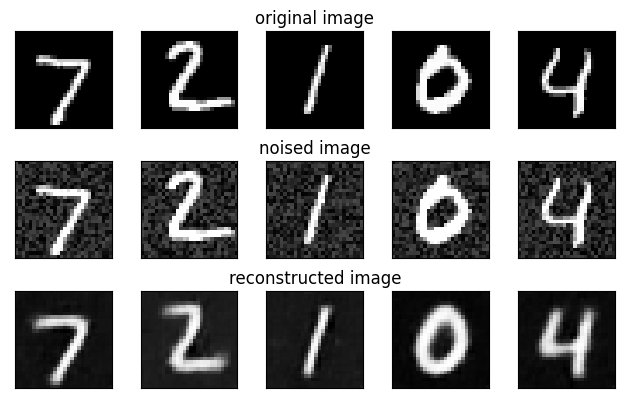

Epoch 20/30

 EPOCH 20/30 	 train loss 0.027 	 val loss 0.045


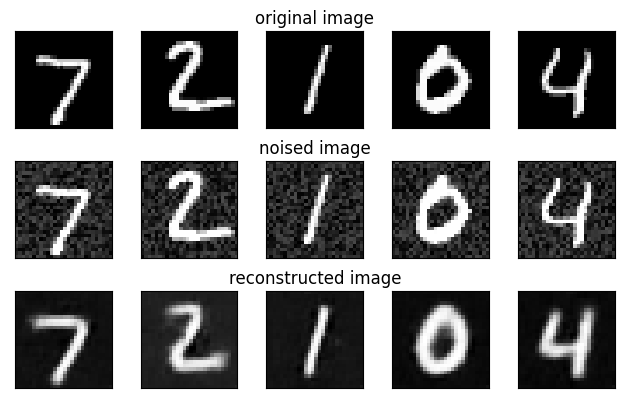

Epoch 21/30

 EPOCH 21/30 	 train loss 0.027 	 val loss 0.045


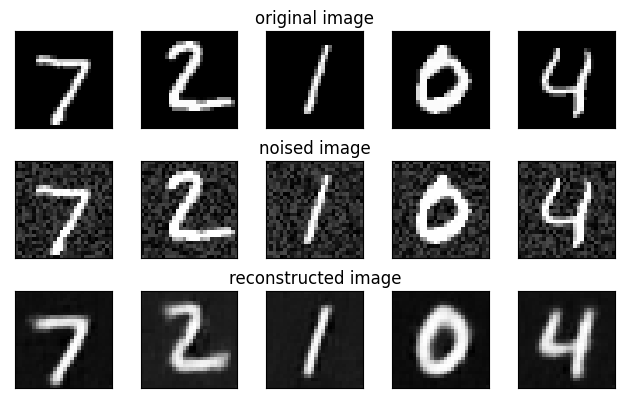

Epoch 22/30

 EPOCH 22/30 	 train loss 0.027 	 val loss 0.044


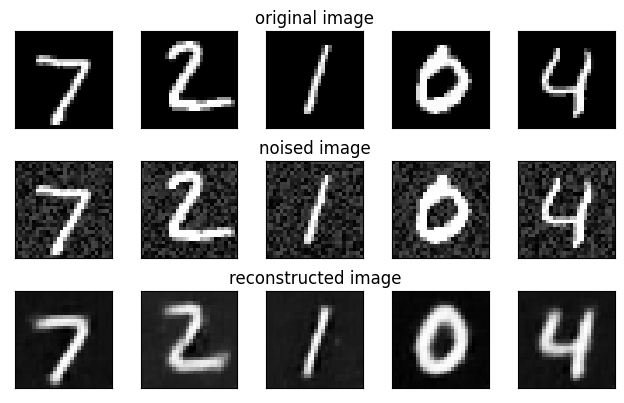

Epoch 23/30

 EPOCH 23/30 	 train loss 0.027 	 val loss 0.044


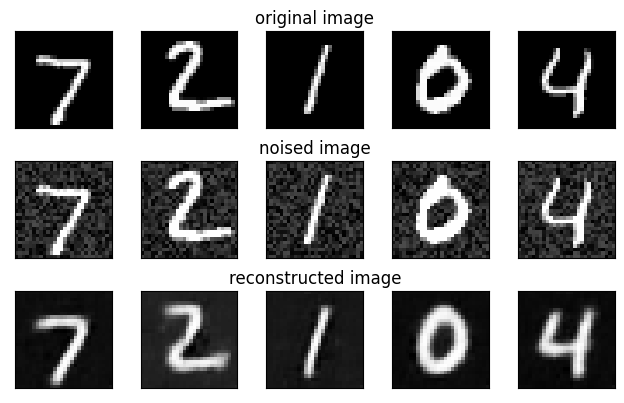

Epoch 24/30

 EPOCH 24/30 	 train loss 0.027 	 val loss 0.044


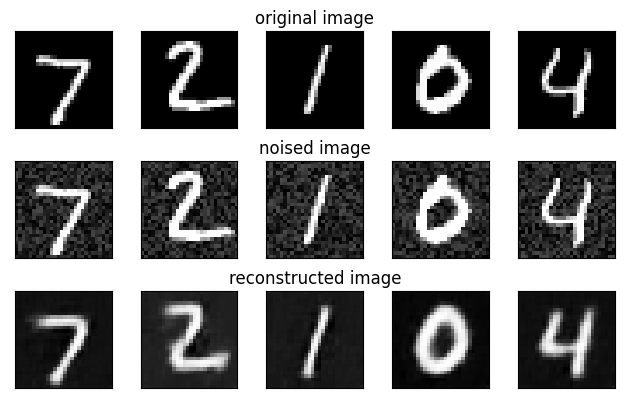

Epoch 25/30

 EPOCH 25/30 	 train loss 0.027 	 val loss 0.044


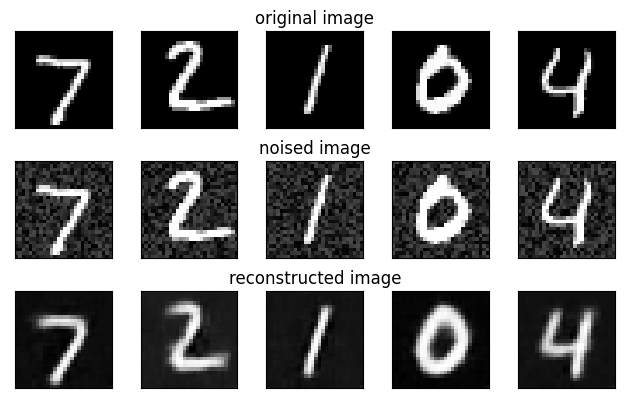

Epoch 26/30

 EPOCH 26/30 	 train loss 0.027 	 val loss 0.045


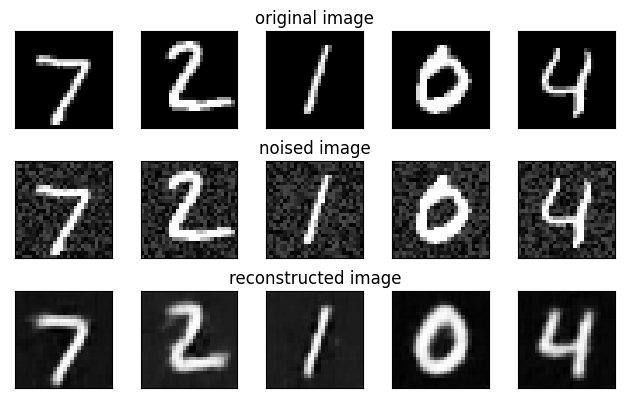

Epoch 27/30

 EPOCH 27/30 	 train loss 0.027 	 val loss 0.044


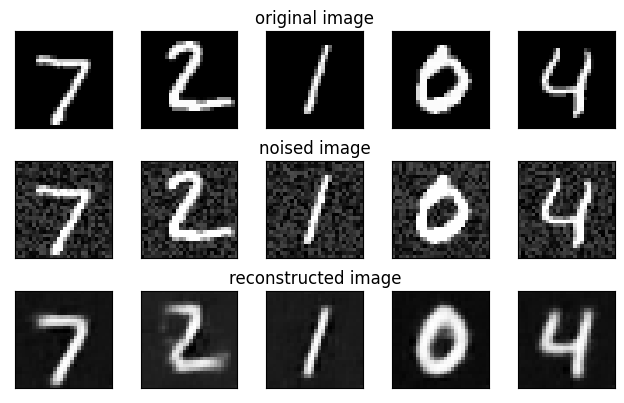

Epoch 28/30

 EPOCH 28/30 	 train loss 0.027 	 val loss 0.045


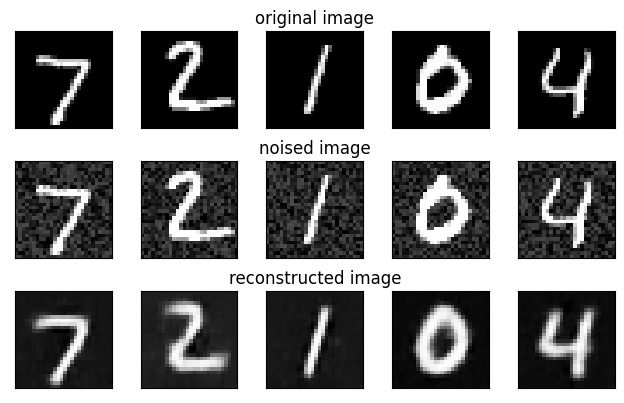

Epoch 29/30

 EPOCH 29/30 	 train loss 0.027 	 val loss 0.044


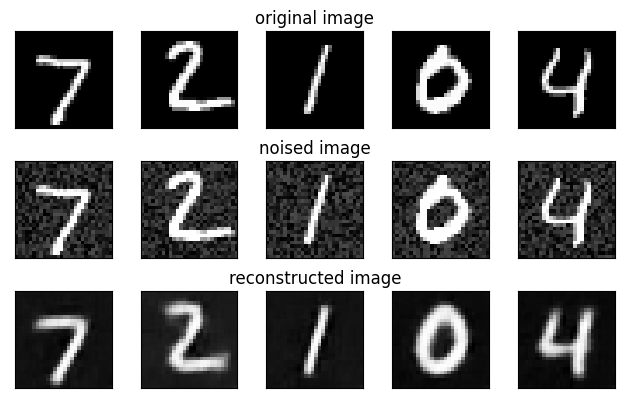

Epoch 30/30

 EPOCH 30/30 	 train loss 0.027 	 val loss 0.044


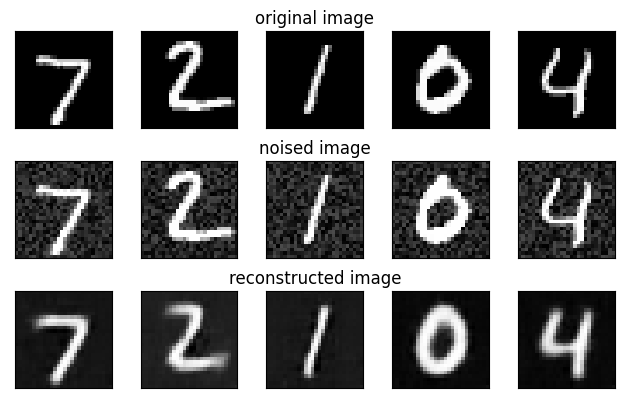

In [42]:
num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
  print('Epoch %d/%d' % (epoch +1, num_epochs))
  train_loss = train_epoch(
    encoder=encoder,
    decoder=decoder,
    device=device,
    dataloader=train_loader,
    loss_fn=loss_fn,
    optimizer=optim,
    noise_factor=0.3
  )
  
  val_loss = test_epoch(
    encoder=encoder,
    decoder=decoder,
    device=device,
    dataloader=test_loader,
    loss_fn=loss_fn,
    noise_factor=0.3
  )
  
  history_da['train_loss'].append(train_loss)
  history_da['val_loss'].append(val_loss)
  print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'
        .format(epoch + 1, num_epochs, train_loss, val_loss))
  plot_ae_outpus(encoder, decoder, noise_factor=0.3)